In [83]:
import numpy as np
import os
import tempfile
import keras
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import History 
from keras.models import load_model
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.layers import Concatenate
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import random



In [2]:
# UPLOAD DATA
# (each user should put datafiles in this directory on their computer)
datapath = "blast_tab_1hit.out"
file = open(datapath, 'r')

same_entries = []
diff_entries = []
max_length_in = 0
max_length_out = 0

for ln in file:
    toks = ln.split('\t')
    max_length_in = max(max_length_in,len(toks[2]))
    max_length_out = max(max_length_out,len(toks[3]))
    if toks[2] == toks[3]:
        same_entries.append([toks[2], toks[3]])
    else:
        diff_entries.append([toks[2], toks[3]])

file.close()
num_entries = len(same_entries) + len(diff_entries)



diff_entries_input = [entry[0] for entry in diff_entries]
diff_entries_output = [entry[1] for entry in diff_entries]
same_entries_input = [entry[0] for entry in same_entries]
same_entries_output = [entry[1] for entry in same_entries]
#diff_entries_output = [("\t" + entry[1] + "\n") for entry in diff_entries] #use '\t' as start character and '\n' as end character
#Visualize
diff_entries_output[1]
one_hot_input = {'A': 0, 'T': 1, 'C': 2, 'G': 3, '-': 4, '\t': 5, '\n': 6}
one_hot_output = {'A': 0, 'T': 1, 'C': 2, 'G': 3}

In [3]:
print(len(diff_entries_input))

58863


In [71]:
numSameEntries = 50000
input_seqs = diff_entries_input + same_entries_input[0:numSameEntries]
output_seqs = diff_entries_output + same_entries_output[0:numSameEntries]
labels = [[1]] * len(diff_entries_input) + [[-1]] * numSameEntries
print(len(labels))
print(len(input_seqs))

c = list(zip(input_seqs, output_seqs, labels))
random.shuffle(c)
input_seqs, output_seqs, labels = zip(*c)

108863
108863


In [72]:
#one hot encode

#ENCODE
encoder_input_data = np.zeros(
    (len(input_seqs), max_length_in, len(one_hot_input)),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_seqs), max_length_out, len(one_hot_input)),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_seqs), max_length_out, len(one_hot_input)),
    dtype='float32')

for i, (input_seqs, output_seqs) in enumerate(zip(input_seqs, output_seqs)):
    for t, char in enumerate(input_seqs):
        encoder_input_data[i, t, one_hot_input[char]] = 1.
    for t, char in enumerate(output_seqs):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, one_hot_input[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, one_hot_input[char]] = 1
            
print(encoder_input_data.shape)
print(decoder_input_data.shape)

(108863, 351, 7)
(108863, 351, 7)


In [99]:
num_encoder_tokens = len(one_hot_input)
num_decoder_tokens = len(one_hot_input)
latent_dim = 100

encoder_inputs = Input(shape=(None, num_encoder_tokens))
e_lstm_1 = Bidirectional(LSTM(latent_dim, return_sequences = True))(encoder_inputs)
e_dropout = Dropout(0.5)(e_lstm_1)
e_lstm_2 = Bidirectional(LSTM(latent_dim, return_sequences = True))(e_dropout)
#e_lstm_3 = Bidirectional(LSTM(latent_dim, return_sequences = True))

output = TimeDistributed(Dense(num_decoder_tokens, activation = "softmax"))(e_lstm_2)
noise_class = Dense(1, activation = "tanh")(Concatenate()([h2, c2]))
#noise_class = Activation("tanh")(noise_class)
print(noise_class)



Tensor("dense_46/Tanh:0", shape=(?, 1), dtype=float32)


In [79]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)

(108863, 351, 7)
(108863, 351, 7)


In [75]:
np.array(labels)

array([[-1],
       [-1],
       [-1],
       ...,
       [-1],
       [ 1],
       [ 1]])

In [80]:
model.summary()
print(model.predict(encoder_input_data[0:2, :, :]))
np.array(labels)[0:2]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, None, 7)           0         
_________________________________________________________________
bidirectional_36 (Bidirectio (None, None, 200)         86400     
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
lstm_49 (LSTM)               [(None, None, 100), (None 120400    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 101       
Total params: 206,901
Trainable params: 206,901
Non-trainable params: 0
_________________________________________________________________
[[0.05149814]
 [0.05149815]]


array([[-1],
       [-1]])

In [94]:
#Train by classification of noisy/non-noisy

model = Model(encoder_inputs, noise_class)

#model.load_weights("seqWeights/LSTM-comboseqs-dropout0.5-manytomany-01-0.82.hdf5")
adam = keras.optimizers.Adam(lr = .001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='binary_crossentropy', metrics = ['accuracy'])

history = History()
filepath="seqWeights/LSTM-test-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

numExamples = 1000
batch_size = 100
epochs = 50
#output_seqs = decoder_input_data[0:numExamples, :, :]
#y = output_seqs.reshape(numExamples, output_seqs.shape[1], 1)
model.fit(encoder_input_data[0:numExamples, :, :],
          np.array(labels)[0:numExamples],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, verbose = 1,
         callbacks = [history, checkpoint])


Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 28s 35ms/step - loss: 1.2089 - acc: 0.0000e+00 - val_loss: 0.9671 - val_acc: 0.0000e+00

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to seqWeights/LSTM-test-01-0.00.hdf5
Epoch 2/50
800/800 [==============================] - 19s 23ms/step - loss: 1.2089 - acc: 0.0000e+00 - val_loss: 0.9671 - val_acc: 0.0000e+00

Epoch 00002: val_acc did not improve from 0.00000
Epoch 3/50
800/800 [==============================] - 18s 23ms/step - loss: 1.2089 - acc: 0.0000e+00 - val_loss: 0.9671 - val_acc: 0.0000e+00

Epoch 00003: val_acc did not improve from 0.00000
Epoch 4/50
800/800 [==============================] - 20s 25ms/step - loss: 1.2089 - acc: 0.0000e+00 - val_loss: 0.9671 - val_acc: 0.0000e+00

Epoch 00004: val_acc did not improve from 0.00000
Epoch 5/50
800/800 [==============================] - 18s 23ms/step - loss: 1.2089 - acc: 0.0000e+00 - val_loss: 0.9671 - val_acc:

KeyboardInterrupt: 

In [101]:
#Train by sequence correctness
model = Model(encoder_inputs, output)

model.load_weights("seqWeights/LSTM-comboseqs-dropout0.5-manytomany-01-0.82.hdf5")
adam = keras.optimizers.Adam(lr = .01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])

history = History()
filepath="seqWeights/LSTM-comboseqs-dropout0.5-manytomany-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

numExamples = 70000
batch_size = 100
epochs = 50
#output_seqs = decoder_input_data[0:numExamples, :, :]
#y = output_seqs.reshape(numExamples, output_seqs.shape[1], 1)
model.fit(encoder_input_data[0:numExamples, :, :],
          decoder_input_data[0:numExamples, :, :],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, verbose = 1,
         callbacks = [history, checkpoint])


Train on 56000 samples, validate on 14000 samples
Epoch 1/50
56000/56000 [==============================] - 84515s 2s/step - loss: 0.0186 - acc: 0.8059 - val_loss: 0.0173 - val_acc: 0.8658

Epoch 00001: val_acc improved from -inf to 0.86578, saving model to seqWeights/LSTM-comboseqs-dropout0.5-manytomany-01-0.87.hdf5
Epoch 2/50


KeyboardInterrupt: 

In [102]:
model.load_weights("seqWeights/LSTM-comboseqs-dropout0.5-manytomany-01-0.87.hdf5")
test_seqs = encoder_input_data[0:10, :, :]

probs = np.array(model.predict(test_seqs))

In [ ]:
indices = np.argmax(probs, axis = -1)
indices.shape

In [103]:
#translate and cal errors
indices = np.argmax(probs, axis = -1)
output_dict = np.array(['A', 'T', 'C', 'G', '-', '\t', '\n'])

error_baseline_sum = 0
error_output_sum = 0
#input_seqs = diff_entries_input + same_entries_input[1:50000]
#output_seqs = diff_entries_output + same_entries_output[1:50000]
input_seqs = encoder_input_data
for i in range(indices.shape[0]):
    pred = ''.join(output_dict[indices[i,]])
    inp = input_seqs[i]
    out = output_seqs[i]
    print("predicted: " + pred)
    print("Input: " + inp)
    print("Output: " + out)
    print('\n')
    
    error_baseline = np.sum([1  for j in range(len(inp)) if inp[j] != out[j] ])
    error_output = np.sum([1  for j in range(len(inp)) if pred[j] != out[j] ])
    error_baseline_sum += error_baseline
    error_output_sum += error_output
                          
    #print("Pred - Input: " +  str(np.sum([1  for i in range(len(inp)) if pred[i] != inp[i] ] )))
    #print("Pred - Output (ie We care): " +  str(error_output ))
    #print("Input - Output (ie Baseline): " +  str(error_baseline ))
    
print("Baseline error (average noisy nucleotide per sequence): " + str(error_baseline_sum / indices.shape[0]))
print("Output error (average noisy nucleotide per sequence): " + str(error_output_sum / indices.shape[0]))
      

predicted: ACAGGGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGCAGGCGGACTTATAAGTCGGGGGTTAAATCCATGTGCTTAACACATGCATGGCTTCCGATACTGTAAGTCTAGAGTCTCGGAGAGGAAGATGGAATTTCCGGTGTAACGGTGGAATGTGTAGATATCGGAAAGAACACCAGTGGCGAAGGCAGTCTTCTGGCCGAGTACTGACGCTCAGGCACGAAAGCGTGGGGAGCAAACAGCCAAGGGCACTCCCACACACACGCCAACAACAACAACAACAACAACAACAACAACAACAACAACAACAACAACAACAACAACACCACAGACAGCAACCAG
Input: ACGGAGGGTGCGAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGCTTGGTAAGTCAGGGGTGAAAGCCCGCGGCTCAACCGCGGAATTGCCTTTGATACTGC-CGAGCTAGAGTCCGGGAGAGGGTAGTGGAATTCCAGGTGTAGGAGTGAAATCCGTAGAGATCTGGAGGAACATCAGTGGCGAAGGCGACTACCTGGACCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG
Output: ACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAAGCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGGCCACCTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG


predicted: ACGGAGGGGGTTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGACCAGAAAGTTGGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTC

In [342]:
#save history and continue training
with open("seqWeights/LSTM-manytomany.txt", 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
model.load_weights("seqWeights/LSTM-manytomany-17-0.87.hdf5")
adam = keras.optimizers.Adam(lr = .001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])
model.fit(encoder_input_data[0:numExamples, :, :],
          decoder_input_data[0:numExamples, :, :],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, verbose = 1,
         callbacks = [history, checkpoint])

Train on 5600 samples, validate on 1400 samples
Epoch 1/100
5600/5600 [==============================] - 742s 133ms/step - loss: 0.0276 - acc: 0.8640 - val_loss: 0.0230 - val_acc: 0.8619

Epoch 00001: val_acc did not improve from 0.87103
Epoch 2/100
5600/5600 [==============================] - 713s 127ms/step - loss: 0.0254 - acc: 0.8169 - val_loss: 0.0216 - val_acc: 0.7565

Epoch 00002: val_acc did not improve from 0.87103
Epoch 3/100
5600/5600 [==============================] - 718s 128ms/step - loss: 0.0242 - acc: 0.7669 - val_loss: 0.0209 - val_acc: 0.7493

Epoch 00003: val_acc did not improve from 0.87103
Epoch 4/100
5600/5600 [==============================] - 714s 127ms/step - loss: 0.0232 - acc: 0.7606 - val_loss: 0.0200 - val_acc: 0.7620

Epoch 00004: val_acc did not improve from 0.87103
Epoch 5/100
5600/5600 [==============================] - 718s 128ms/step - loss: 0.0223 - acc: 0.7445 - val_loss: 0.0198 - val_acc: 0.7167

Epoch 00005: val_acc did not improve from 0.87103
Ep


Epoch 00043: val_acc did not improve from 0.87103
Epoch 44/100
5600/5600 [==============================] - 714s 127ms/step - loss: 0.0176 - acc: 0.7592 - val_loss: 0.0168 - val_acc: 0.7580

Epoch 00044: val_acc did not improve from 0.87103
Epoch 45/100
5600/5600 [==============================] - 713s 127ms/step - loss: 0.0172 - acc: 0.7589 - val_loss: 0.0166 - val_acc: 0.7532

Epoch 00045: val_acc did not improve from 0.87103
Epoch 46/100
5600/5600 [==============================] - 713s 127ms/step - loss: 0.0171 - acc: 0.7594 - val_loss: 0.0165 - val_acc: 0.7604

Epoch 00046: val_acc did not improve from 0.87103
Epoch 47/100
5600/5600 [==============================] - 720s 129ms/step - loss: 0.0165 - acc: 0.7593 - val_loss: 0.0165 - val_acc: 0.7594

Epoch 00047: val_acc did not improve from 0.87103
Epoch 48/100
5600/5600 [==============================] - 714s 127ms/step - loss: 0.0161 - acc: 0.7600 - val_loss: 0.0159 - val_acc: 0.7652

Epoch 00048: val_acc did not improve from 0.


Epoch 00086: val_acc did not improve from 0.87103
Epoch 87/100
5600/5600 [==============================] - 720s 129ms/step - loss: 0.0197 - acc: 0.7721 - val_loss: 0.0177 - val_acc: 0.7561

Epoch 00087: val_acc did not improve from 0.87103
Epoch 88/100
5600/5600 [==============================] - 710s 127ms/step - loss: 0.0277 - acc: 0.7632 - val_loss: 0.0259 - val_acc: 0.7795

Epoch 00088: val_acc did not improve from 0.87103
Epoch 89/100
5600/5600 [==============================] - 715s 128ms/step - loss: 0.0279 - acc: 0.7514 - val_loss: 0.0248 - val_acc: 0.7384

Epoch 00089: val_acc did not improve from 0.87103
Epoch 90/100
5600/5600 [==============================] - 709s 127ms/step - loss: 0.0259 - acc: 0.7420 - val_loss: 0.0224 - val_acc: 0.7281

Epoch 00090: val_acc did not improve from 0.87103
Epoch 91/100
5600/5600 [==============================] - 719s 128ms/step - loss: 0.0228 - acc: 0.7227 - val_loss: 0.0196 - val_acc: 0.7214

Epoch 00091: val_acc did not improve from 0.

In [145]:
batch_size = 50
epochs = 50
numExamples = 10000


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#model.load_weights("seqWeights/LSTM7layer-05-0.82.hdf5")
adam = keras.optimizers.Adam(lr = .01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])

# Run training
history = History()
filepath="LSTM7layer-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


model.fit([encoder_input_data[0:numExamples, :, :], decoder_input_data[0:numExamples, :, :]], decoder_target_data[0:numExamples, :, :],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2, verbose = 1,
          callbacks = [history, checkpoint])


Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 9441s 1s/step - loss: 0.9891 - acc: 0.2595 - val_loss: 0.9704 - val_acc: 0.2642

Epoch 00001: val_acc improved from -inf to 0.26419, saving model to LSTM7layer-01-0.26.hdf5


C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer lstm_84 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_77/while/Exit_2:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'lstm_77/while/Exit_3:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer lstm_85 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_78/while/Exit_2:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'lstm_78/while/Exit_3:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '
C:\Users\ctata\Miniconda3\envs\tensorflow\lib\

Epoch 2/50
5100/8000 [==================>...........] - ETA: 27:29 - loss: 0.9641 - acc: 0.2678

KeyboardInterrupt: 

In [343]:
model.load_weights("seqWeights/LSTM-manytomany-17-0.87.hdf5")

In [125]:
encoder_model_inf = Model(encoder_inputs, [e_h1, e_c1, e_h2, e_c2, e_h3, e_c3, e_h4, e_c4])

In [126]:
#Inference on new sequence

d_input_states = [d_input_h1, d_input_c1, d_input_h2, d_input_c2, d_input_h3, d_input_c3, d_input_h4, d_input_c4]
d_input_h1 = Input(shape = (latent_dim, ))
d_input_c1 = Input(shape = (latent_dim, ))
d_input_h2 = Input(shape = (latent_dim, ))
d_input_c2 = Input(shape = (latent_dim, ))
d_input_h3 = Input(shape = (latent_dim, ))
d_input_c3 = Input(shape = (latent_dim, ))
d_input_h4 = Input(shape = (latent_dim, ))
d_input_c4 = Input(shape = (latent_dim, ))


d_out_1, d_h1, d_c1 = d_lstm_1(decoder_inputs, initial_state = [d_input_h1, d_input_c1])
d_out_2, d_h2, d_c2 = d_lstm_2(d_out_1, initial_state = [d_input_h2, d_input_c2])
d_out_3, d_h3, d_c3 = d_lstm_3(d_out_2, initial_state = [d_input_h3, d_input_c3])
d_out_4, d_h4, d_c4 = d_lstm_4(d_out_3, initial_state = [d_input_h4, d_input_c4])

d_output_states = [d_h1, d_c1, d_h2, d_c2, d_h3, d_c3, d_h4, d_c4 ]

decoder_out = d_dense(d_out_4)
decoder_model_inf = Model(inputs = [decoder_inputs] + [d_input_h1, d_input_c1, d_input_h2, d_input_c2, d_input_h3, d_input_c3, d_input_h4, d_input_c4],
                         outputs = [decoder_out] + [d_h1, d_c1, d_h2, d_c2, d_h3, d_c3, d_h4, d_c4 ])

In [127]:
index_to_nuc = ['A', 'T', 'C', 'G', '-', '\t', '\n']
def decode_seq(inp_seq):
    print(inp_seq.shape)
    states = encoder_model_inf.predict(inp_seq)
    print(len(states))
    target_seq = np.zeros((1,1,num_decoder_tokens))
    target_seq[0,0, one_hot_input['\t']] = 1
    
    translated_seq = ''
    stop_condition = False
    
    while not stop_condition:
        decoder_out, d_h1, d_c1, d_h2, d_c2, d_h3, d_c3, d_h4, d_c4  = decoder_model_inf.predict(x = [target_seq] + states)
        
        max_val_index = np.argmax(decoder_out[0, -1, :])
        sampled_nucleotide = index_to_nuc[max_val_index]
        translated_seq += sampled_nucleotide
        
        if (sampled_nucleotide == '\n'):
            stop_condition = True
        
        target_seq = np.zeros((1,1, num_decoder_tokens))
        target_seq[0,0, max_val_index] = 1
        
        states = [d_h1, d_c1, d_h2, d_c2, d_h3, d_c3, d_h4, d_c4]
    return(translated_seq)

'ACAGGGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGCAGGCGGATTCATAAGTCGGGGGTTAAATCCATGTGCTTAACACATGCAAGGCTTCCGATACTGTGAGTCTATAGTCTCGAAGAGGAAGATGGAATTTCCGGTGTAACGGTGGAATGTGTAGATATCGGAAAGAACACCAGTGGCGAAGGCAGTCTTCTGGTCGAGAACTGACGCTCAGGCACGAAAGCGTGGGGAGCAAACAG'

In [136]:
input_seqs = diff_entries_input
output_seqs = diff_entries_output

for i in range(10):
    input_seq = np.array(np.expand_dims(encoder_input_data[i, :, :], axis = 0))
    trans_seq = decode_seq(input_seq)
    print("Original Sequence: " + input_seqs[i])
    print("Predicted Sequence: " + trans_seq)
    print("Target Sequence: " + output_seqs[i])
    
#Metric can be standard confusion matrix: of the bases that should have been substituted, how many were substituted correctly (true positive)
#of the bases that should not have been substituted, how many were not substituted, true negative
# of the bases that should not have been substituted, how many were: false positive
# of the bases that should have been substituted, how many were not: false negative.

(1, 351, 7)
8
Original Sequence: ACGGAGGGTGCGAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGCTTGGTAAGTCAGGGGTGAAAGCCCGCGGCTCAACCGCGGAATTGCCTTTGATACTGC-CGAGCTAGAGTCCGGGAGAGGGTAGTGGAATTCCAGGTGTAGGAGTGAAATCCGTAGAGATCTGGAGGAACATCAGTGGCGAAGGCGACTACCTGGACCGGTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG
Predicted Sequence: ACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAAGCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGGCCACCTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG

Target Sequence: 	ACGGAGGGTGCAAGCGTTAATCGGAATCACTGGGCGTAAAGCGCACGTAGGCTGTTATGTAAGTCAGGGGTGAAAGCCCACGGCTCAACCGTGGAACTGCCCTTGATACTGCACGA-CTCGAATCCGGGAGAGGGTGGCGGAATTCCAGGTGTAGGAGTGAAATCCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGGCCACCTGGACCGGTATTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAG

(1, 351, 7)
8
Original Sequence: ACAGAGGGGGCAAGCGTTGTCCGGAGTTACTGGGCGTAAAGGGCGCGCAGGCGGTGGGCTGCGTCGGCGCTGAAAGCGCCCCGCTTAACGGGGCGAGGCGCGCCGATACGAGTCCACTCGAGGCAAGCAGAGGGT

In [ ]:
#pickle.load(open( "history_lr0.001", "rb" ) )

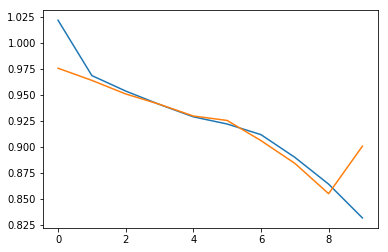

In [83]:
lr = 0.01
history = pickle.load(open('history_lr' + str(lr), "rb"))
def plot_loss(history):
    epochs = len(history["loss"])
    plt.plot(range(0, epochs), history["loss"])
    plt.plot(range(0, epochs), history["val_loss"])
plot_loss(history)

In [59]:
history_new = History()

In [111]:
def continue_train_model(model, history, model_save, history_save, lr = .01, epochs = 10, batch_size = 50):
    
    history_new = History()
    
    adam = keras.optimizers.Adam(lr = lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])
    model.fit([encoder_input_data[0:numExamples, :, :], 
               decoder_input_data[0:numExamples, :, :]],
               decoder_target_data[0:numExamples, :, :],
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2, 
                verbose = 1,
                callbacks = [history_new])

    #update history
    for k in history.keys():
        history[k] = history[k] + history_new.history[k]
    with open(history_save, 'wb') as file_pi:
        pickle.dump(history, file_pi)
        
    #Save model
    model.save(model_save)
    return(model, history)

Train on 5600 samples, validate on 1400 samples
Epoch 1/10
5600/5600 [==============================] - 224s 40ms/step - loss: 0.0798 - acc: 0.7747 - val_loss: 0.0685 - val_acc: 0.7723
Epoch 2/10
5600/5600 [==============================] - 229s 41ms/step - loss: 0.0707 - acc: 0.7751 - val_loss: 0.0598 - val_acc: 0.7758
Epoch 3/10
5600/5600 [==============================] - 232s 41ms/step - loss: 0.1394 - acc: 0.7452 - val_loss: 0.1471 - val_acc: 0.7368
Epoch 4/10
5600/5600 [==============================] - 234s 42ms/step - loss: 0.1315 - acc: 0.7457 - val_loss: 0.1064 - val_acc: 0.7546
Epoch 5/10
5600/5600 [==============================] - 234s 42ms/step - loss: 0.1164 - acc: 0.7536 - val_loss: 0.1231 - val_acc: 0.7497
Epoch 6/10
5600/5600 [==============================] - 186s 33ms/step - loss: 0.1119 - acc: 0.7528 - val_loss: 0.0914 - val_acc: 0.7563
Epoch 7/10
5600/5600 [==============================] - 183s 33ms/step - loss: 0.0977 - acc: 0.7573 - val_loss: 0.0834 - val_acc: 

C:\Users\ctata\Miniconda3\envs\tensorflow\lib\site-packages\keras\engine\topology.py:2379: UserWarning: Layer lstm_12 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_11_15/while/Exit_2:0' shape=(?, 100) dtype=float32>, <tf.Tensor 'lstm_11_15/while/Exit_3:0' shape=(?, 100) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


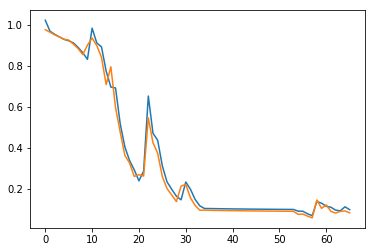

In [113]:
#Load and continue training as desired
lr = 0.001
model = load_model('s2s_lr.01_lr.001.h5')
history = pickle.load(open('history_lr.01_ly.001.h5', "rb"))

model, history = continue_train_model(model = model, history = history, model_save = ('s2s_lr.01_lr.001.h5'), history_save = ('history_lr.01_ly.001.h5'), 
                                      lr = .001, epochs = 10, batch_size = 50)
 
    
plot_loss(history)

In [ ]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [54]:
def define_model_multilayer(num_encoder_tokens, num_decoder_tokens):
    model = Sequential()
    model.add(Embedding(input_dim = num_encoder_tokens, output_dim=162))
    model.add(LSTM(units = 100, return_sequences=True, input_shape = (None, 162))) #None refers to unknown sequence length
    model.add(LSTM(100, return_sequences = True))
    model.add(LSTM(50, return_sequences = True))
    model.add(Dense(162, activation = "softmax"))
    adam = keras.optimizers.Adam(lr = .01, beta_1=0.9, beta_2 = 0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer= adam, loss='categorical_crossentropy', metrics = ['accuracy'])
    
    return(model)
              

In [55]:

#With more latent dimensions
numExamples = 5000
batch_size = 50
epochs = 2

model = define_model_multilayer(num_encoder_tokens = 7, num_decoder_tokens = 7)
history = History()

print(len(diff_entries_input[0]))
print(encoder_input_data[1, 1, :])
print(encoder_input_data[0:numExamples, :, :].shape)
#model.fit(encoder_input_data[0:numExamples, :, :],
#          decoder_target_data[0:numExamples, :, :],
#          batch_size=batch_size,
#          epochs=epochs,
#          validation_split=0.1, 
#          verbose = 1,
#          callbacks = [history])

model.fit(np.array(diff_entries_input)[0:numExamples, ],
          np.array(diff_entries_output)[0:numExamples, ],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1, 
          verbose = 1,
          callbacks = [history])

252
[0. 0. 1. 0. 0. 0. 0.]
(5000, 351, 7)


ValueError: Error when checking target: expected dense_16 to have 3 dimensions, but got array with shape (5000, 1)

In [41]:
probs = model.predict(encoder_input_data[0:5, :, :])
print(len(probs))
probs = np.array(probs)
print(probs.shape)
indices = np.argmax(probs, axis = -1)

output_dict = np.array(['A', 'T', 'C', 'G', '-', '\t', '\n'])
for i in range(indices.shape[0]):
    print(output_dict[indices[i,]])
    


5
(5, 351, 7)
[0 2 3 3 0 3 3 3 1 3 2 3 0 3 2 3 1 1 0 0 1 2 3 3 0 0 1 2 0 2 1 3 3 3 2 3 1
 0 0 0 3 2 3 2 0 2 3 1 0 3 3 2 1 3 2 1 1 3 3 1 0 0 3 1 2 0 3 3 3 3 1 3 0 0
 0 3 2 2 2 3 2 3 3 2 1 2 0 0 2 2 3 2 3 3 0 0 1 1 3 2 2 1 1 1 3 0 1 0 2 1 3
 2 0 2 3 0 3 2 1 0 3 0 3 1 2 2 3 3 3 0 3 0 3 3 3 1 0 3 1 3 3 0 0 1 1 2 2 0
 3 3 1 3 1 0 3 3 0 3 1 3 0 0 0 1 2 2 3 1 0 3 0 3 0 1 2 1 3 3 0 3 3 0 0 2 0
 1 2 0 3 1 3 3 2 3 0 0 3 3 2 3 0 2 1 0 2 2 1 3 3 0 2 2 3 3 1 0 2 1 3 0 2 3
 2 1 3 0 3 3 1 3 2 3 0 0 0 3 2 3 1 3 3 3 3 0 3 2 0 0 0 2 0 3 6 2 2 2 2 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
['A' 'C' 'G' 'G' 'A' 'G' 'G' 'G' 'T' 'G' 'C' 'G' 'A' 'G' 'C' 'G' 'T' 'T'
 'A' 'A' 'T' 'C' 'G' 'G' 'A' 'A' 'T' 'C' 'A' 'C' 'T' 'G' 'G' 'G' 'C' 'G'
 'T' 'A' 'A' 'A' 'G' 'C' 'G' 'C' 'A' 'C' 'G' 'T' 'A' 'G' 'G' 'C' 'T' 'G'
 'C' 'T' 'T' 'G' 'G' 'T' 'A' 'A' 'G' 'T' 'C' 'A' 'G' '